In [1]:
from pathlib import Path
import yaml
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
from pprint import pprint

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_sweep"

##### Plot 1: Regression performance

In [2]:
# load regression results
reg_res = defaultdict(dict)

for method_dir in PRED_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                with open(dataset_dir / "metadata.yaml", "r") as f:
                    reg_res[method_dir.name][dataset_dir.name] = yaml.safe_load(f)

reg_res = dict(reg_res)

In [3]:
y_labels = [
    "gb",
    # "rf",
    "ridge",
    "jp_const_gb_part",
    # "jp_const_rf_part",
    # "jp_linear_gb_part",
    # "jp_linear_rf_part",
    "fastel",
    # "lf",
    # "jp_linear_linforest_part",
    # "jp_const_linforest_part",
    # "jp_linear",
    # "jp_linear_mu",
    "nn",
    # "jp_linear_lingb_part",
]

shared_datasets = [set(reg_res[k].keys()) for k in y_labels]
shared_datasets = set.intersection(*shared_datasets)
# shared_datasets = set(reg_res["gb"].keys())

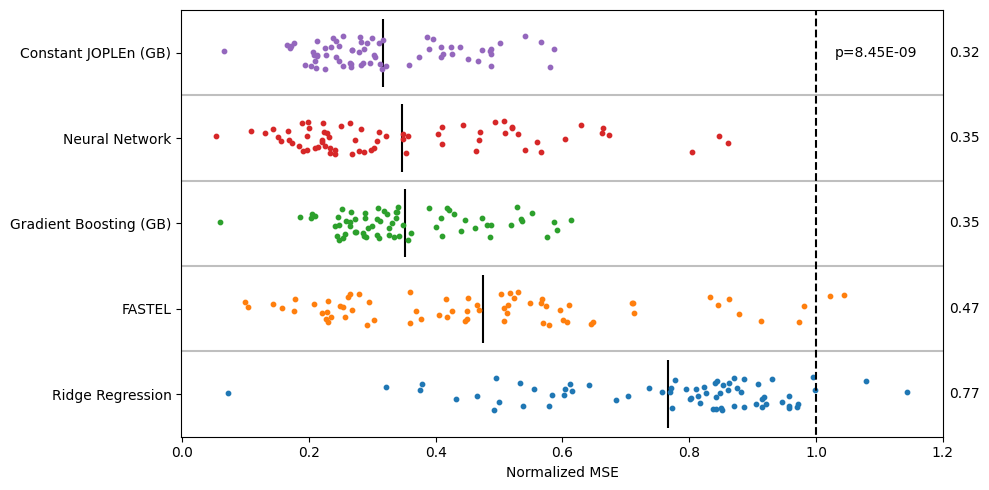

In [4]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)
    else:
        fig = ax.get_figure()

    for x_idx, x_values in enumerate(arr):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
        ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, x_lim[0] - 1, x_lim[1] + 1, color="k", alpha=0.25)

    ax.set_xlim(x_lim)

    return ax


renamer = {
    "gb": "Gradient Boosting (GB)",
    "rf": "Random Forest (RF)",
    "ridge": "Ridge Regression",
    "jp_const_gb_part": "Constant JOPLEn (GB)",
    "jp_const_rf_part": "Constant JOPLEn (RF)",
    "jp_linear_gb_part": "Linear JOPLEn (GB)",
    "jp_linear_rf_part": "Linear JOPLEn (RF)",
    "fastel": "FASTEL",
    "lf": "Linear Forest (LF)",
    "jp_linear_linforest_part": "Linear JOPLEn (LF)",
    "jp_const_linforest_part": "Constant JOPLEn (LF)",
    "jp_linear": "Linear JOPLEn (Voronoi)",
    # "jp_linear_mu": "Linear JOPLEn (Voronoi)",
    "nn": "Neural Network",
}

x_values = []

for method in y_labels:
    tmp_x_values = []
    for k, v in reg_res[method].items():
        if k in shared_datasets:
            tmp_x_values.append(v["test_score"] / v["dummy_loss"])

    x_values.append(tmp_x_values)

argsort = np.argsort([np.mean(x) for x in x_values])[::-1]
x_values = [x_values[i] for i in argsort]
y_labels = [y_labels[i] for i in argsort]

# compute p values
pval_groups = {
    "gb": [
        "jp_const_gb_part",
        # "jp_linear_gb_part",
    ],
    # "rf": [
    #     "jp_const_rf_part",
    #     "jp_linear_rf_part",
    # ],
    # "lf": [
    #     "jp_linear_linforest_part",
    #     "jp_const_linforest_part",
    # ],
}

pvals = {}

for original, group in pval_groups.items():
    orig_idx = y_labels.index(original)
    for refit_method in group:
        refit_idx = y_labels.index(refit_method)

        pvals[refit_method] = wilcoxon(
            x_values[orig_idx],
            x_values[refit_idx],
            alternative="greater",
        ).pvalue

fig, ax = plt.subplots(figsize=(10, 5))

# add short line where mean is and write it on the right side of the plot
for i, group in enumerate(y_labels):
    mean_val = np.mean(x_values[i])
    ax.vlines(mean_val, i - 0.4, i + 0.4, color="k", linestyle="-", zorder=0)
    ax.text(
        1.21,
        i,
        f"{mean_val:.2f}",
        horizontalalignment="left",
        verticalalignment="center",
    )

plot_strip(
    x_values,
    scatter_kwargs=dict(
        s=10,
        alpha=1.0,
        zorder=1,
    ),
    ax=ax,
)

# add pvalues to the right side of the plot
for i, group in enumerate(y_labels):
    if group in pvals:
        ax.text(
            1.03,
            i,
            f"p={pvals[group]:.2E}",
            horizontalalignment="left",
            verticalalignment="center",
        )

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels([renamer.get(y, y) for y in y_labels])

ax.set_xticks(np.arange(0, 1.3, 0.2))

y_lim = ax.get_ylim()
ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")
ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

plt.xlabel("Normalized MSE")

plt.tight_layout()
# plt.savefig("plots/fig1.pdf")

plt.show()

In [5]:
print(y_labels)

for xval, label in zip(x_values, y_labels):
    print(label, wilcoxon(
            xval,
            x_values[-1],
            alternative="greater",
        ).pvalue)

['ridge', 'fastel', 'gb', 'nn', 'jp_const_gb_part']
ridge 5.245204471273063e-13
fastel 4.6541322224905963e-07
gb 8.446599409138916e-09
nn 0.3194107100434026


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [103]:
jp = reg_res["jp_const_gb_part"]
gb = reg_res["gb"]

scores = {
    k: {
        "jp": np.around(gb[k]["test_score"], 4),
        "gb": np.around(jp[k]["test_score"], 4),
    }
    for k in jp
}

scores

{'579_fri_c0_250_5': {'jp': 0.4901, 'gb': 0.5212},
 '606_fri_c2_1000_10': {'jp': 0.2253, 'gb': 0.1778},
 '651_fri_c0_100_25': {'jp': 0.4838, 'gb': 0.4518},
 '505_tecator': {'jp': 1.0023, 'gb': 0.9443},
 '657_fri_c2_250_10': {'jp': 0.311, 'gb': 0.3564},
 '599_fri_c2_1000_5': {'jp': 0.2097, 'gb': 0.192},
 '596_fri_c2_250_5': {'jp': 0.2017, 'gb': 0.2586}}

In [12]:
# 30, 1.13e-8

In [148]:
# compute p values for fastel vs all other methods
pvals = {}

for method in y_labels:
    if method != "fastel":
        pvals[method] = wilcoxon(
            x_values[y_labels.index("fastel")],
            x_values[y_labels.index(method)],
            alternative="greater",
        ).pvalue

pprint(pvals)

{'gb': 5.849609526411041e-05,
 'jp_const_gb_part': 1.23916358105298e-07,
 'jp_const_linforest_part': 0.45447566491694935,
 'jp_const_rf_part': 0.0050629910282098045,
 'jp_linear_gb_part': 1.6361156149630725e-07,
 'jp_linear_linforest_part': 5.174999575021668e-07,
 'jp_linear_mu': 0.9999993894717534,
 'jp_linear_rf_part': 0.008458215798196618,
 'lf': 0.004265331039644356,
 'nn': 2.9536627537391355e-09,
 'rf': 0.6727946051406651,
 'ridge': 0.9999999998959391}


##### Figure 2: Feature selection

In [149]:
# load data

st_sel_res = defaultdict(lambda: defaultdict(list))

for method_dir in STFS_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                metadata = defaultdict(list)
                for file in dataset_dir.iterdir():
                    if file.suffix == ".yaml":
                        with open(file, "r") as f:
                            file_content = yaml.safe_load(f)

                        density = file_content["model"]["results"]["density"]
                        metadata["density"].append(density)

                        test_err = file_content["model"]["score"]["norm_error"]["test"]
                        metadata["error"].append(test_err)

                st_sel_res[method_dir.name][dataset_dir.name] = dict(metadata)

for k, v in st_sel_res.items():
    st_sel_res[k] = dict(v)

st_sel_res = dict(st_sel_res)

In [150]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]

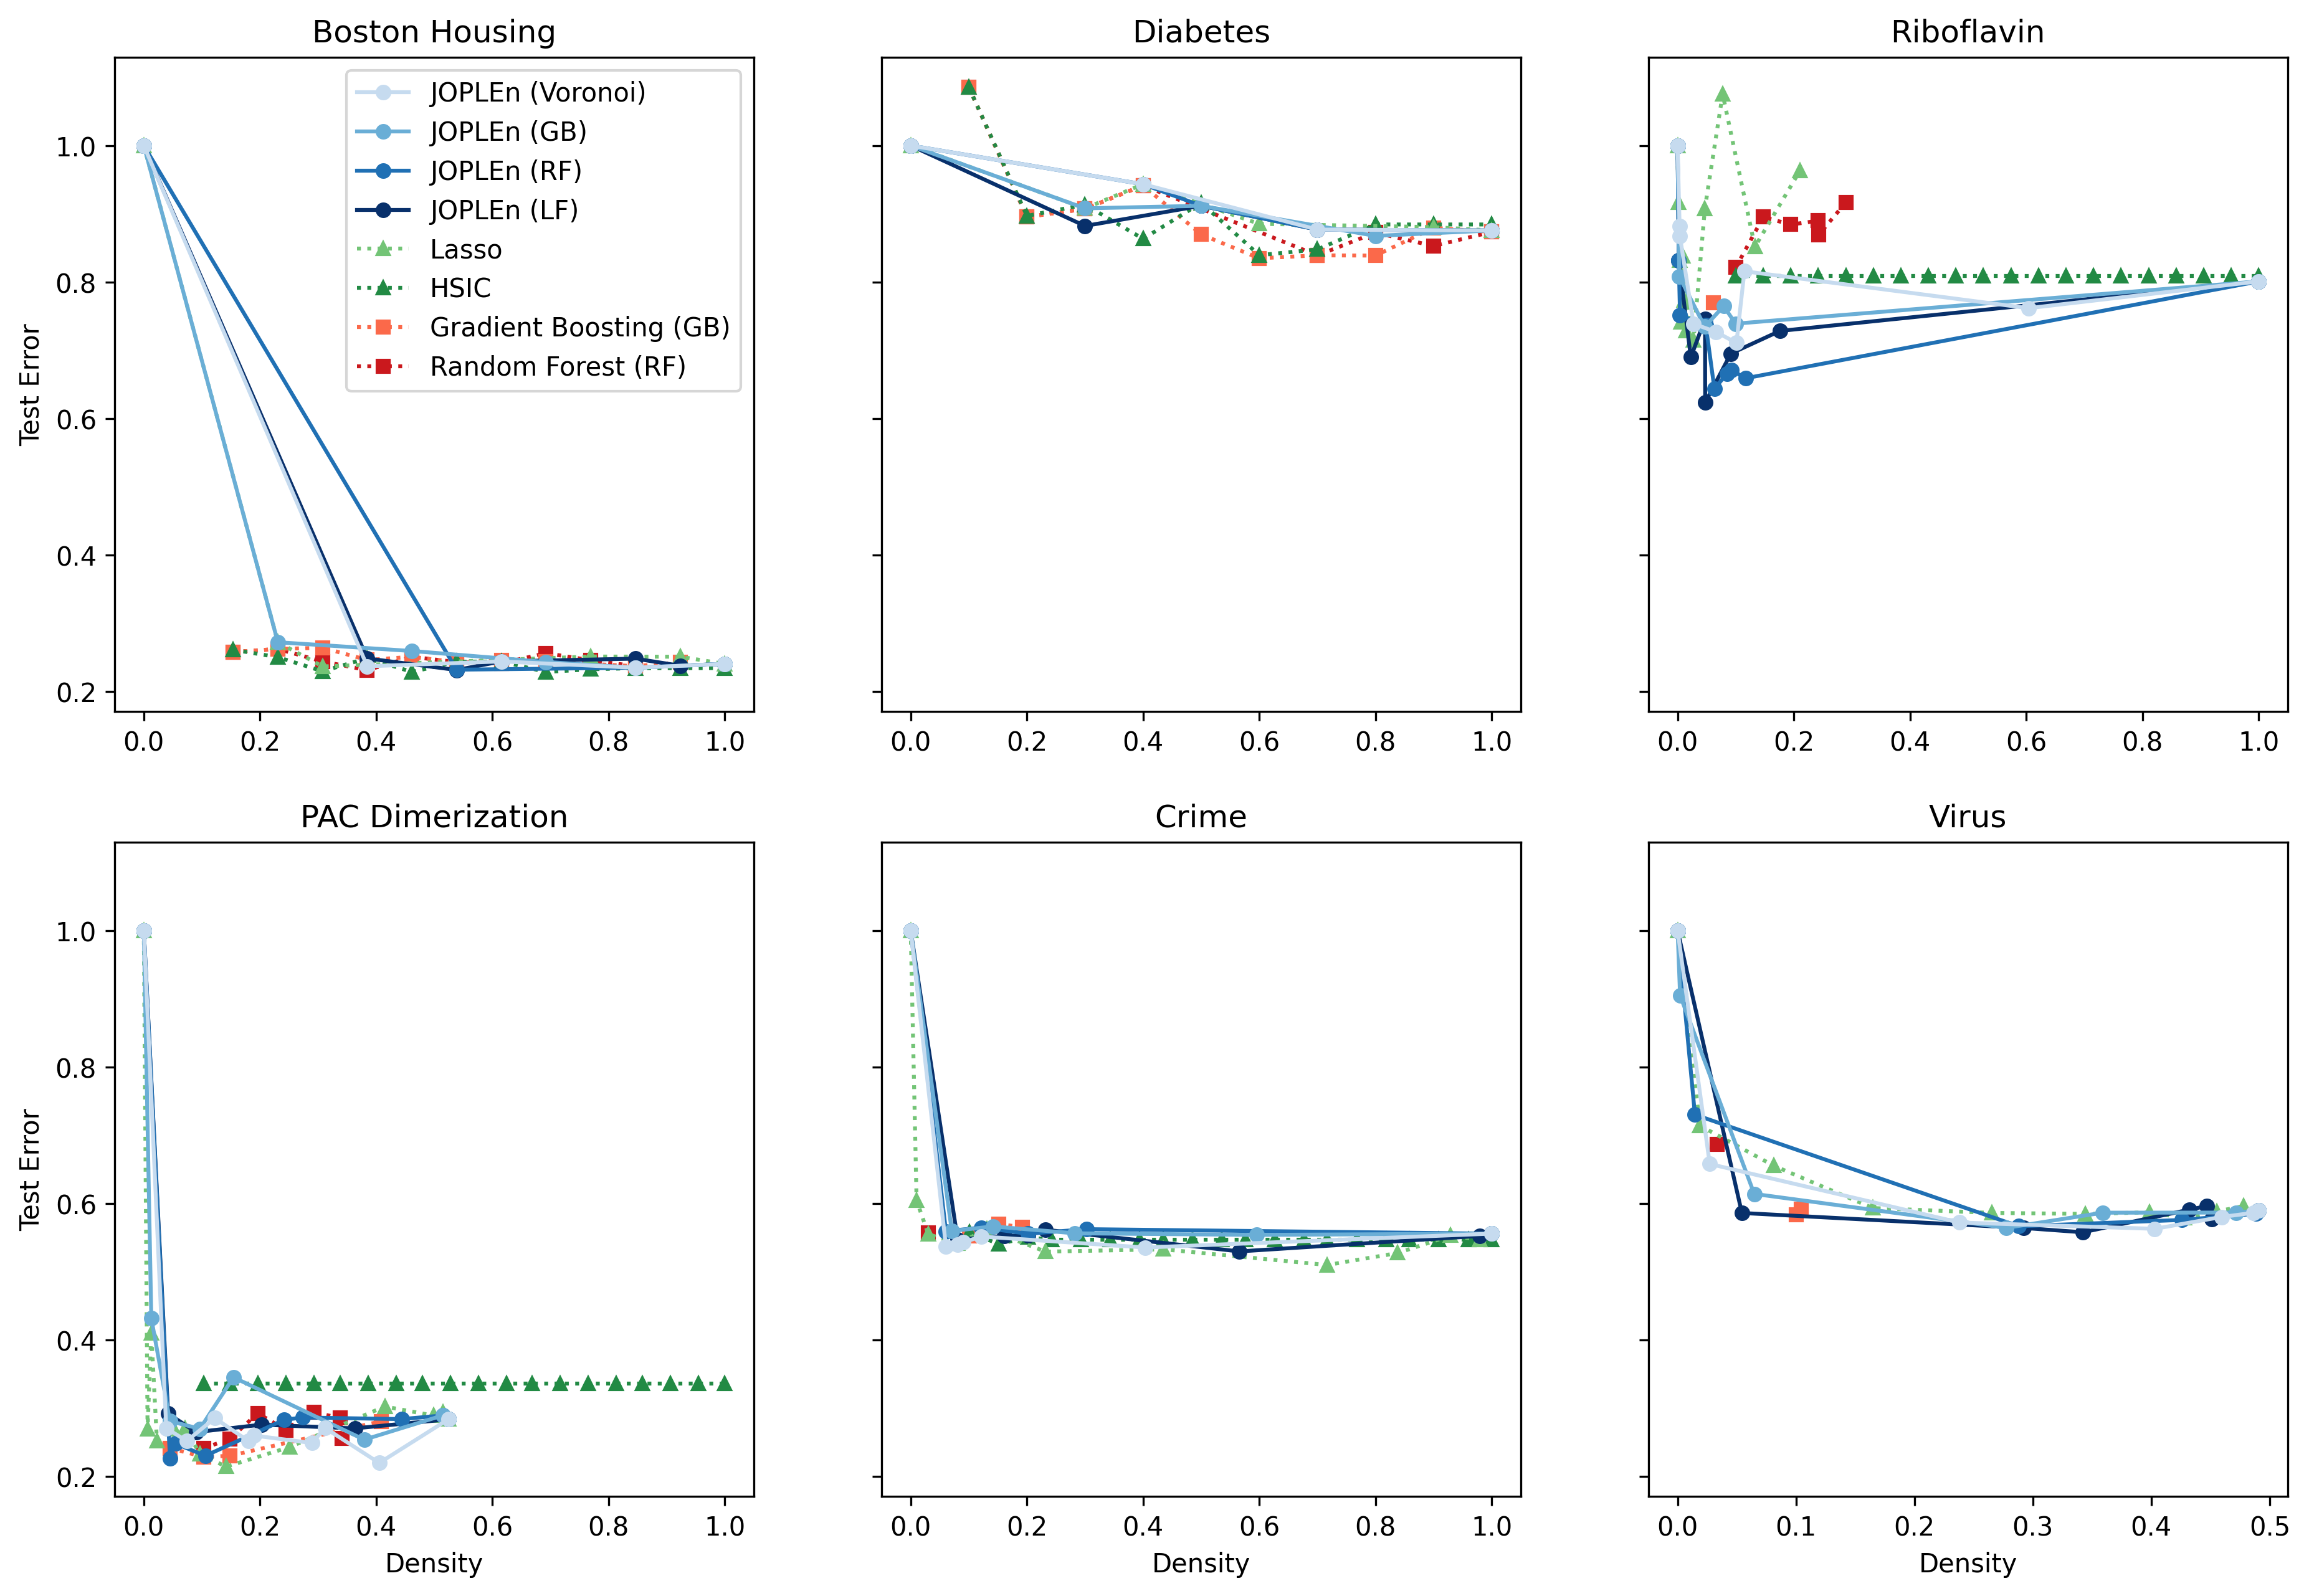

In [151]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Generate colormaps
green_colormap = ListedColormap(
    cm.Blues(np.linspace(0.25, 1.0, 4))
)  # 4 shades of green
red_colormap = ListedColormap(cm.Greens(np.linspace(0.5, 0.75, 2)))  # 2 shades of red
blue_colormap = ListedColormap(cm.Reds(np.linspace(0.5, 0.75, 2)))  # 2 shades of blue

LST_DATASETS = [
    "boston",
    "diabetes",
    "riboflavin",
    "pac_dimerization",
    "crime",
    "virus",
]

LST_METHODS = [
    "jp_linear_mu",
    "jp_linear_gb_part",
    "jp_linear_rf_part",
    "jp_linear_linforest_part",
    "lasso",
    "hsic",
    "gb",
    "rf",
    # "nn",
]

solid = LST_METHODS[:4]

colors = [
    *green_colormap.colors,
    *red_colormap.colors,
    *blue_colormap.colors,
]

markers = [
    *(["o"] * 4),
    *(["^"] * 2),
    *(["s"] * 2),
]

renamer = {
    "lasso": "Lasso",
    "gb": "Gradient Boosting (GB)",
    "rf": "Random Forest (RF)",
    "hsic": "HSIC",
    "jp_linear_mu": "JOPLEn (Voronoi)",
    "jp_linear_gb_part": "JOPLEn (GB)",
    "jp_linear_rf_part": "JOPLEn (RF)",
    "jp_linear_linforest_part": "JOPLEn (LF)",
    "nn": "Deep Feature Selection",
    "boston": "Boston Housing",
    "pac_dimerization": "PAC Dimerization",
}


n_ds = len(LST_DATASETS)

fig, axs = plt.subplots(2, n_ds // 2, figsize=(5 * n_ds // 2, 10), sharey=True, dpi=300)

zorder = 10

for ax, ds in zip(axs.ravel(), LST_DATASETS):
    for i, (k, c, m) in enumerate(zip(LST_METHODS, colors, markers)):
        if ds not in st_sel_res[k]:
            continue

        model_score = np.array(st_sel_res[k][ds]["error"])
        model_density = np.array(st_sel_res[k][ds]["density"])

        pareto_density, pareto_score = pareto_front(model_score, model_density)
        ax.plot(
            pareto_density,
            pareto_score,
            label=renamer[k],
            marker=m,
            linestyle="-" if k in solid else ":",
            color=c,
            markersize=5,
            zorder=zorder - i,
        )

    ax.set_title(renamer.get(ds, ds.title()))

axs[0, 0].legend()

for ax in axs.T:
    ax[1].set_xlabel("Density")

for ax in axs:
    ax[0].set_ylabel("Test Error")

plt.savefig("plots/fig2.pdf")
plt.show()

##### Singletask sparsity pattern

In [152]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(weights, transpose=False, figsize=(5, 5)):
    n_feats, n_cells = weights.shape
    weights = weights

    weights = scale_matrix(weights, weights.min(), weights.max())

    fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True, sharex=True, dpi=300)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    if not transpose:
        ax.matshow(weights, **params)
        ax.set_xlabel("Partitions and cells")
        ax.set_ylabel("Features")
    else:
        ax.matshow(weights.T, **params)
        ax.set_xlabel("Features")
        ax.set_ylabel("Partitions and cells")

    plt.tight_layout()
    return fig, ax

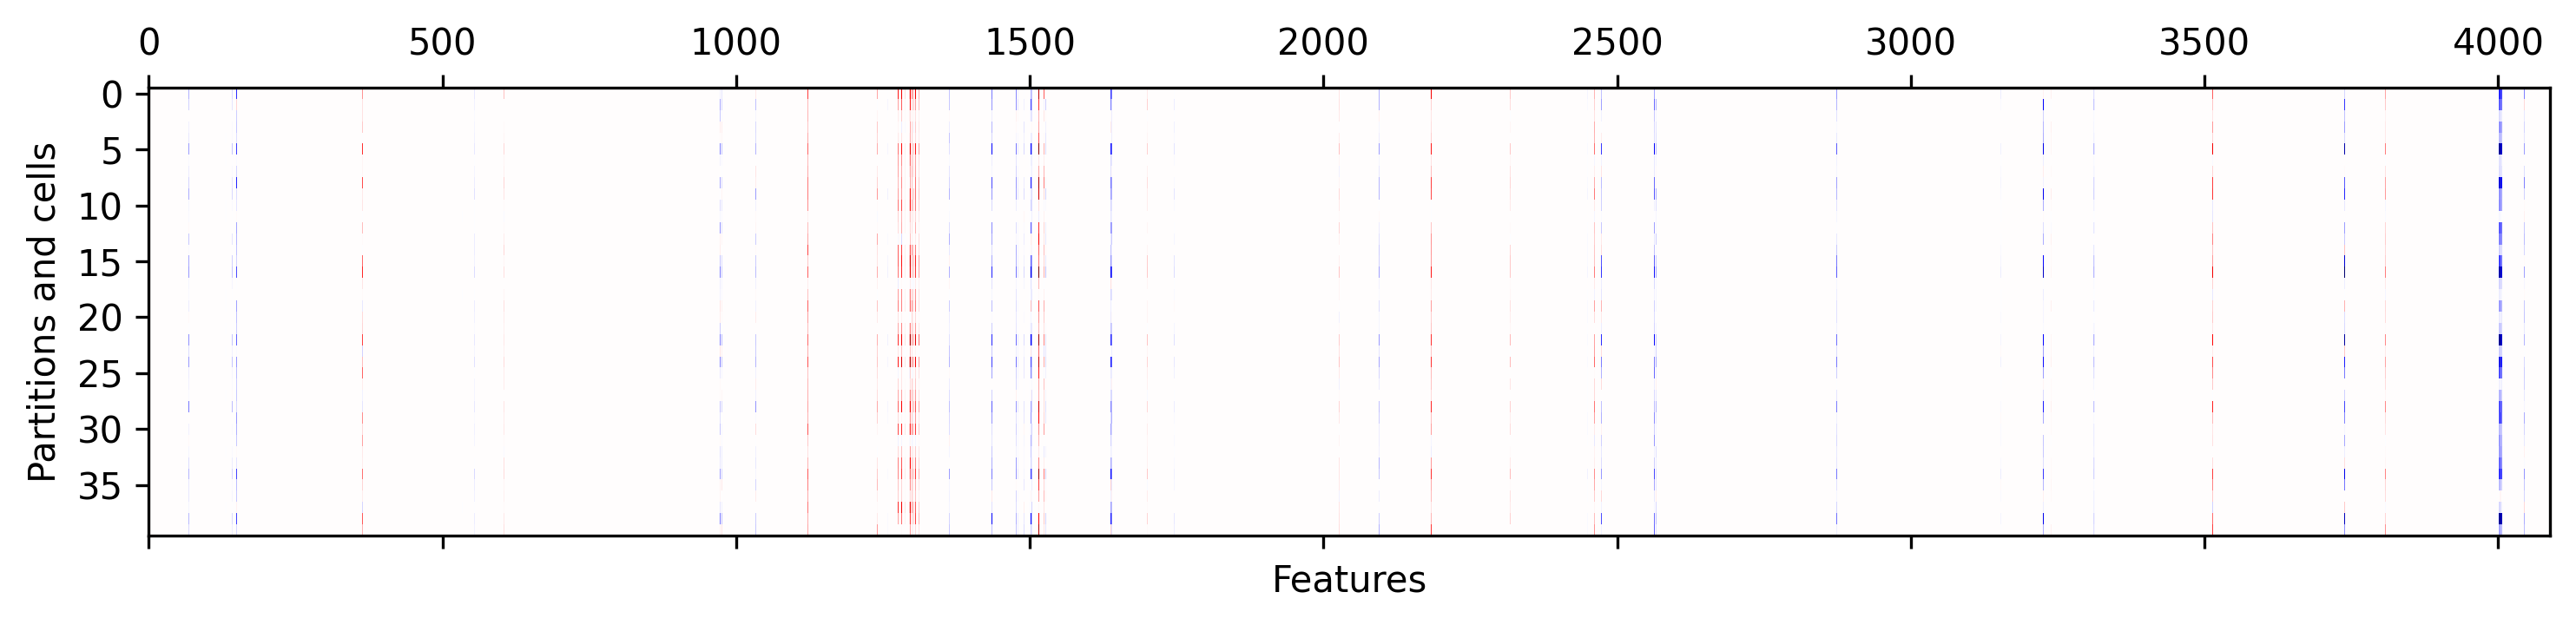

In [153]:
misc_data_path = Path() / "misc_data"

riboflavin_weights = np.loadtxt(
    misc_data_path / "riboflavin_weights.csv",
    delimiter=",",
)

_, ax = plot_joplen_weights(riboflavin_weights, True, (10, 2.5))

plt.savefig("plots/fig3.pdf", bbox_inches="tight")
plt.show()

##### Multitask sparsity pattern

In [154]:
def plot_joplen_weights(core_weights, task_weights, axs=None):
    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    if axs is None:
        fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    # axs[0].set_title("Common weights")
    axs[1].matshow(task_weights, **params)
    # axs[1].set_title("Task-specific weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_ylabel("Features")

    axs[1].set_xlabel("Tasks, partitions, and cells")

    plt.tight_layout()

    return ax

In [155]:
import pandas as pd

OUT_PATH = Path() / "experiments" / "manual" / "multitask"


# load data
def load_results(dataset):
    path = OUT_PATH / dataset

    # prediction performance
    jp_res = pd.read_csv(path / "joplen.csv", index_col=0)
    dl_res = pd.read_csv(path / "dl.csv", index_col=0)
    dummy_results = pd.read_csv(path / "dummy.csv", index_col=0)
    linear_results = pd.read_csv(path / "linear.csv", index_col=0)
    gb_results = pd.read_csv(path / "gb.csv", index_col=0)

    # weights
    jp_path = path / "joplen"
    jp_core = np.load(jp_path / "core.npy")
    jp_task = np.load(jp_path / "task.npy")

    dl_path = path / "dirty_lasso"
    dl_core = np.load(dl_path / "core.npy")
    dl_task = np.load(dl_path / "task.npy")

    return (
        jp_res,
        dl_res,
        dummy_results,
        linear_results,
        gb_results,
        jp_core,
        jp_task,
        dl_core,
        dl_task,
    )

In [156]:
res = load_results("sarcos")
(
    sarcos_jp_res,
    sarcos_dl_res,
    sarcos_dummy_results,
    sarcos_linear_results,
    sarcos_gb_results,
    sarcos_jp_core,
    sarcos_jp_task,
    sarcos_dl_core,
    sarcos_dl_task,
) = res

res = load_results("parkinsons")
(
    park_jp_res,
    park_dl_res,
    park_dummy_results,
    park_linear_results,
    park_gb_results,
    park_jp_core,
    park_jp_task,
    park_dl_core,
    park_dl_task,
) = res

res = load_results("nanoparticle")
(
    nano_jp_res,
    nano_dl_res,
    nano_dummy_results,
    nano_linear_results,
    nano_gb_results,
    nano_jp_core,
    nano_jp_task,
    nano_dl_core,
    nano_dl_task,
) = res

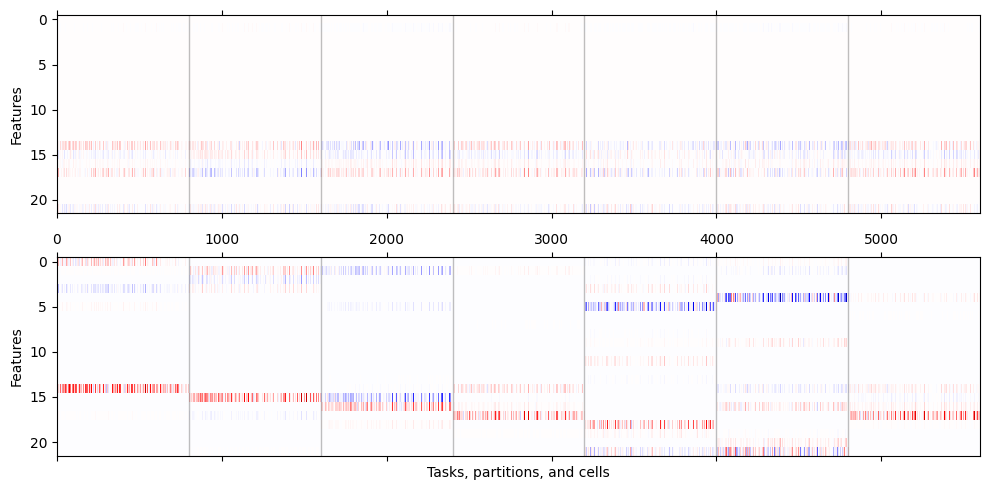

In [157]:
ax = plot_joplen_weights(sarcos_jp_core, sarcos_jp_task)

plt.savefig("plots/fig4.pdf", bbox_inches="tight")

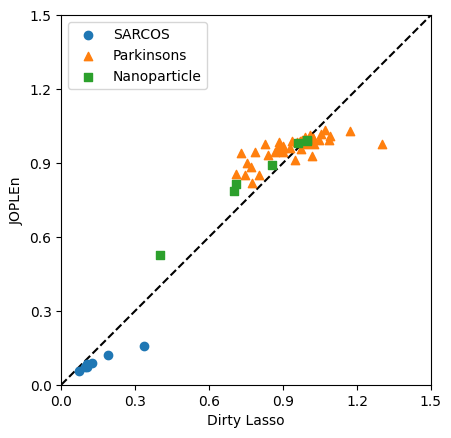

In [158]:
plt.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

plt.scatter(
    park_dl_res["test"] / park_dummy_results["test"],
    park_jp_res["test"] / park_dummy_results["test"],
    label="Parkinsons",
    marker="^",
    zorder=10,
)

plt.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Nanoparticle",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

plt.plot(x, x, color="k", linestyle="--", zorder=0)

plt.xticks(x)
plt.yticks(x)

plt.xlabel("Dirty Lasso")
plt.ylabel("JOPLEn")
plt.legend()
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.gca().set_aspect("equal")

plt.show()

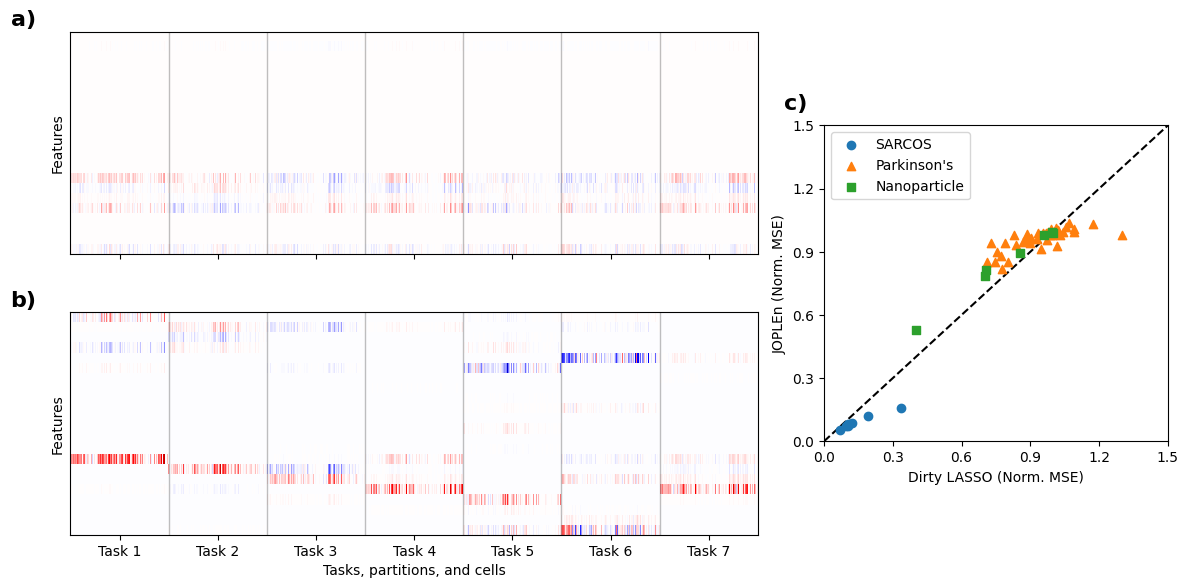

In [162]:
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(12, 6))  # Adjust the overall size of the figure

# Define the GridSpec layout
# The right plot will only take up 75% of the vertical space and be center aligned
gs = GridSpec(6, 2, width_ratios=[2, 1])

# Create three subplots
ax1 = fig.add_subplot(gs[0:3, 0])  # Top left (occupying the first half vertically)
ax2 = fig.add_subplot(
    gs[3:6, 0], sharex=ax1, sharey=ax1
)  # Bottom left (occupying the second half vertically)
ax3 = fig.add_subplot(
    gs[1:5, 1]
)  # Right (center aligned and taking up 75% of vertical space)

# plot sparsity
plot_joplen_weights(sarcos_jp_core, sarcos_jp_task, axs=[ax1, ax2])

# plot performance
ax3.scatter(
    sarcos_dl_res["test"] / sarcos_dummy_results["test"],
    sarcos_jp_res["test"] / sarcos_dummy_results["test"],
    label="SARCOS",
    marker="o",
    zorder=10,
)

ax3.scatter(
    park_dl_res["test"] / park_dummy_results["test"],
    park_jp_res["test"] / park_dummy_results["test"],
    label="Parkinson's",
    marker="^",
    zorder=10,
)

ax3.scatter(
    nano_dl_res["test"] / nano_dummy_results["test"],
    nano_jp_res["test"] / nano_dummy_results["test"],
    label="Nanoparticle",
    marker="s",
    zorder=10,
)

x = np.linspace(0, 1.5, 6, endpoint=True)

ax3.plot(x, x, color="k", linestyle="--", zorder=0)

ax3.set_xticks(x)
ax3.set_yticks(x)

ax3.set_xlabel("Dirty LASSO (Norm. MSE)")
ax3.set_ylabel("JOPLEn (Norm. MSE)")
ax3.legend()
ax3.set_xlim(0, 1.5)
ax3.set_ylim(0, 1.5)

for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 7) * 800 + 400)
    ax.tick_params(labelleft=False, left=False)

ax1.set_xticklabels([f"Task {i}" for i in range(1, 8)])

ax1.tick_params(top=False, labeltop=False, bottom=True, labelbottom=False)
ax2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

text_params = {
    "fontsize": 16,
    "fontweight": "bold",
    "va": "top",
    "ha": "right",
}

# Add number to each subplot
ax1.text(-0.05, 1.1, "a)", transform=ax1.transAxes, **text_params)
ax2.text(-0.05, 1.1, "b)", transform=ax2.transAxes, **text_params)
ax3.text(-0.05, 1.1, "c)", transform=ax3.transAxes, **text_params)

# Show the plot layout
plt.tight_layout()
plt.savefig("plots/fig4.pdf", bbox_inches="tight")
plt.show()

NameError: name 'NAMES' is not defined

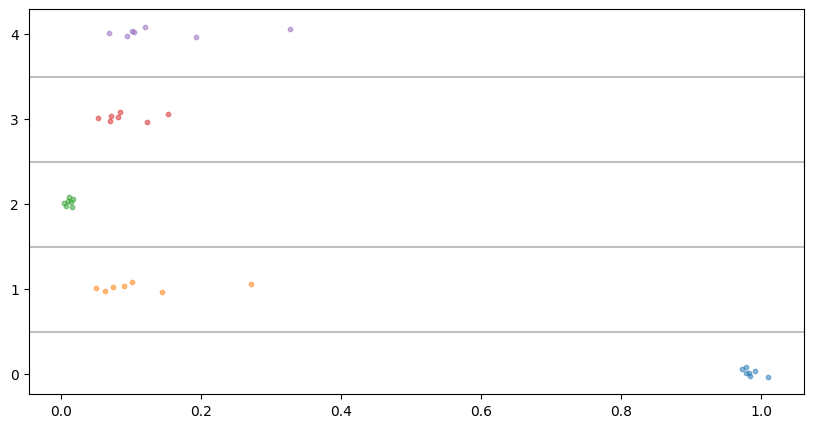

In [160]:
scores = [dummy_results, linear_results, gb_results, jp_res, dl_res]
scores = np.array([s["test"].to_numpy() for s in scores])

plot_strip(
    scores,
    plot_kwargs={"figsize": (10, 5)},
    scatter_kwargs={"alpha": 0.5, "s": 10},
)
plt.yticks(np.arange(len(NAMES)), NAMES)

plt.xlim(0, 5)

plt.show()